###1. Implement the following layers as python functions(both forward and backward propagation)
* Inner-product layer
* Activation layer(Sigmoid or Rectified)
* Softmax layer

###2. Implement training and testing process
* included cross-validation

###3. Plot epoch-accuracy curves


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/EAI_lab1

/content/drive/MyDrive/EAI_lab1


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# load MNIST dataset
image_size = 28           # width and length
no_of_different_labels = 10     #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
train_data = np.loadtxt("mnist_train.csv", delimiter=",")
test_data = np.loadtxt("mnist_test.csv", delimiter=",")

# data preprocessing

# map pixels information from range(0, 255) to range(0.01, 1)
fac = 0.99 / 255
train_imgs = np.asarray(train_data[:, 1:]) * fac + 0.01
test_imgs = np.asarray(test_data[:, 1:]) * fac + 0.01

print(train_imgs.shape)
train_labels = np.asarray(train_data[:, :1])
test_labels = np.asarray(test_data[:, :1])

lr = np.arange(no_of_different_labels)

# transform labels into one hot representation
train_labels_one_hot = (lr==train_labels).astype(np.float64)
test_labels_one_hot = (lr==test_labels).astype(np.float64)


(60000, 784)


In [5]:
# Separate train_imgs, train_labels into training and validation

split_ratio = 0.8   # 80% for training, 20% for validation
split_index = int(len(train_imgs) * split_ratio)

train_imgs_manual = train_imgs[:split_index]
val_imgs_manual = train_imgs[split_index:]
train_labels_one_hot_manual = train_labels_one_hot[:split_index]
val_labels_one_hot_manual = train_labels_one_hot[split_index:]

print("Manual training images shape:", train_imgs_manual.shape)
print("Manual validation images shape:", val_imgs_manual.shape)
print("Manual training labels shape:", train_labels_one_hot_manual.shape)
print("Manual validation labels shape:", val_labels_one_hot_manual.shape)

Manual training images shape: (48000, 784)
Manual validation images shape: (12000, 784)
Manual training labels shape: (48000, 10)
Manual validation labels shape: (12000, 10)


In [6]:
#layer definition
def InnerProduct_ForProp(x,W,b):
    """
    Computes the forward pass for an inner product layer.

    Args:
        x: Input to the layer.
        W: Weights of the layer.
        b: Bias of the layer.

    Returns:
        The output of the inner product layer.
    """
    y = np.dot(x, W) + b
    return y

def InnerProduct_BackProp(dEdy,x,W,b):
    """
    Computes the backward pass for an inner product layer.

    Args:
        dEdy: Gradient of the loss with respect to the output.
        x: Input to the layer.
        W: Weights of the layer.
        b: Bias of the layer.

    Returns:
        dEdx: Gradient of the loss with respect to the input.
        dEdW: Gradient of the loss with respect to the weights.
        dEdb: Gradient of the loss with respect to the bias.
    """
    dEdx = np.dot(dEdy, W.T)
    dEdW = np.dot(x.T, dEdy)
    dEdb = np.sum(dEdy, axis=0)
    return dEdx, dEdW, dEdb

def Softmax_ForProp(x):
    """
    Computes the forward pass for a softmax layer.

    Args:
        x: Input to the layer.

    Returns:
        The output probabilities of the softmax layer.
    """
    # Subtract the maximum value for numerical stability
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    y = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    return y

def Softmax_BackProp(y,t):
    """
    Computes the backward pass for a softmax layer with cross-entropy loss.

    Args:
        y: Predicted output probabilities.
        t: True labels (one-hot encoded).

    Returns:
        dEdx: Gradient of the loss with respect to the input.
    """
    dEdx = y - t
    return dEdx

def Sigmoid_ForProp(x):
    """
    Computes the forward pass for a sigmoid activation function.

    Args:
        x: Input to the activation function.

    Returns:
        The output of the sigmoid activation function.
    """
    y = 1 / (1 + np.exp(-x))
    return y

def Sigmoid_BackProp(dEdy,x):
    """
    Computes the backward pass for a sigmoid activation function.

    Args:
        dEdy: Gradient of the loss with respect to the output.
        x: Input to the activation function.

    Returns:
        dEdx: Gradient of the loss with respect to the input.
    """
    sigmoid_output = Sigmoid_ForProp(x)
    dEdx = dEdy * sigmoid_output * (1 - sigmoid_output)
    return dEdx

def Rectified_ForProp(x):
    """
    Computes the forward pass for a Rectified Linear Unit (ReLU) activation function.

    Args:
        x: Input to the activation function.

    Returns:
        The output of the ReLU activation function.
    """
    y = np.maximum(0, x)
    return y

def Rectified_BackProp(dEdy,x):
    """
    Computes the backward pass for a Rectified Linear Unit (ReLU) activation function.

    Args:
        dEdy: Gradient of the loss with respect to the output.
        x: Input to the activation function.

    Returns:
        dEdx: Gradient of the loss with respect to the input.
    """
    dEdx = dEdy * (x > 0)
    return dEdx

# you can also create your own class which includes each layer

In [12]:
# Initialize the model
input_size = image_pixels
hidden_size = 128
hidden_size2 = 64
output_size = no_of_different_labels
learning_rate = 0.01
iteration = 100
batch_size = 128

# Initialize weights and bias
W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1. / input_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, hidden_size2) * np.sqrt(1. / hidden_size)
b2 = np.zeros((1, hidden_size2))
W3 = np.random.randn(hidden_size2, output_size) * np.sqrt(1. / hidden_size2)
b3 = np.zeros((1, output_size))

# record accuracy and loss
train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
val_loss_list = []

In [13]:
# NN Functions definition
def forward_propagation(x, W1, b1, W2, b2, W3, b3):
    z1 = InnerProduct_ForProp(x, W1, b1)
    a1 = Rectified_ForProp(z1)
    z2 = InnerProduct_ForProp(a1, W2, b2)
    a2 = Sigmoid_ForProp(z2)
    z3 = InnerProduct_ForProp(a2, W3, b3)
    a3 = Softmax_ForProp(z3)
    return z1, a1, z2, a2, z3, a3

def backward_propagation(x, t, z1, a1, z2, a2, z3, a3, W1, b1, W2, b2, W3, b3):
    dEdy = Softmax_BackProp(a3, t)
    dEdz3, dEdW3, dEdb3 = InnerProduct_BackProp(dEdy, a2, W3, b3)
    dEda2 = Sigmoid_BackProp(dEdz3, z2)
    dEdz2, dEdW2, dEdb2 = InnerProduct_BackProp(dEda2, a1, W2, b2)
    dEda1 = Rectified_BackProp(dEdz2, z1)
    dEdx, dEdW1, dEdb1 = InnerProduct_BackProp(dEda1, x, W1, b1)
    return dEdW1, dEdb1, dEdW2, dEdb2, dEdW3, dEdb3

def update_weights(W1, b1, W2, b2, W3, b3, dEdW1, dEdb1, dEdW2, dEdb2, dEdW3, dEdb3, learning_rate):
    W1 -= learning_rate * dEdW1
    b1 -= learning_rate * dEdb1
    W2 -= learning_rate * dEdW2
    b2 -= learning_rate * dEdb2
    W3 -= learning_rate * dEdW3
    b3 -= learning_rate * dEdb3
    return W1, b1, W2, b2, W3, b3

def cross_entropy_loss(z3, t):
    N = z3.shape[0]
    z3_max = np.max(z3, axis=1, keepdims=True)
    log_sum_exp = z3_max + np.log(np.sum(np.exp(z3 - z3_max), axis=1, keepdims=True))
    loss = -np.sum(t * (z3 - log_sum_exp)) / N
    return loss

def compute_accuracy(a3, t):
    predicted_labels = np.argmax(a3, axis=1)
    true_labels = np.argmax(t, axis=1)
    accuracy = np.mean(predicted_labels == true_labels)
    return accuracy

In [14]:
for i in range(iteration):
    # Initialize epoch loss and accuracy
    epoch_train_loss = 0.0
    epoch_train_accuracy = 0.0
    num_batches = 0

    for batch_start in range(0, len(train_imgs_manual), batch_size):
        batch_end = min(batch_start + batch_size, len(train_imgs_manual))
        batch_imgs = train_imgs_manual[batch_start:batch_end]
        batch_labels = train_labels_one_hot_manual[batch_start:batch_end]

        # Forward-propagation
        z1, a1, z2, a2, z3, a3 = forward_propagation(batch_imgs, W1, b1, W2, b2, W3, b3)

        # compute training accuracy
        batch_loss = cross_entropy_loss(z3, batch_labels)
        batch_accuracy = compute_accuracy(a3, batch_labels)

        epoch_train_loss += batch_loss * (batch_end - batch_start)
        epoch_train_accuracy += batch_accuracy * (batch_end - batch_start)
        num_batches += (batch_end - batch_start)

        # Backward-propagation
        dEdW1, dEdb1, dEdW2, dEdb2, dEdW3, dEdb3 = backward_propagation(
            batch_imgs, batch_labels,
            z1, a1, z2, a2, z3, a3, W1, b1, W2, b2, W3, b3
        )

        # Parameter Updating (Gradient decent)
        W1, b1, W2, b2, W3, b3 = update_weights(
            W1, b1, W2, b2, W3, b3,
            dEdW1, dEdb1, dEdW2, dEdb2, dEdW3, dEdb3,
            learning_rate
        )

    # Update average epoch loss and accuracy
    epoch_train_loss /= num_batches
    epoch_train_accuracy /= num_batches

    # Use validation data to evaluate model
    z1_val, a1_val, z2_val, a2_val, z3_val, a3_val = forward_propagation(
        val_imgs_manual, W1, b1, W2, b2, W3, b3
    )

    # compute validation accuracy
    val_accuracy = compute_accuracy(a3_val, val_labels_one_hot_manual)
    val_loss = cross_entropy_loss(z3_val, val_labels_one_hot_manual)

    if i%10 == 0:
      # record data
      train_accuracy_list.append(epoch_train_accuracy)
      val_accuracy_list.append(val_accuracy)
      train_loss_list.append(epoch_train_loss)
      val_loss_list.append(val_loss)

      print(f"Epoch {i+1}: Training Loss = {epoch_train_loss:.4f}, Training Accuracy = {epoch_train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}")


Epoch 1: Training Loss = 0.4596, Training Accuracy = 0.8544, Validation Accuracy = 0.9373
Epoch 11: Training Loss = 0.0117, Training Accuracy = 0.9981, Validation Accuracy = 0.9763
Epoch 21: Training Loss = 0.0016, Training Accuracy = 1.0000, Validation Accuracy = 0.9792
Epoch 31: Training Loss = 0.0007, Training Accuracy = 1.0000, Validation Accuracy = 0.9794
Epoch 41: Training Loss = 0.0004, Training Accuracy = 1.0000, Validation Accuracy = 0.9792
Epoch 51: Training Loss = 0.0003, Training Accuracy = 1.0000, Validation Accuracy = 0.9792
Epoch 61: Training Loss = 0.0002, Training Accuracy = 1.0000, Validation Accuracy = 0.9790
Epoch 71: Training Loss = 0.0002, Training Accuracy = 1.0000, Validation Accuracy = 0.9791
Epoch 81: Training Loss = 0.0002, Training Accuracy = 1.0000, Validation Accuracy = 0.9792
Epoch 91: Training Loss = 0.0001, Training Accuracy = 1.0000, Validation Accuracy = 0.9792


In [15]:
# Using test_images and test_labels to do the final test
test_z1, test_a1, test_z2, test_a2, test_z3, test_a3 = forward_propagation(
    test_imgs, W1, b1, W2, b2, W3, b3
)
test_accuracy = compute_accuracy(test_a3, test_labels_one_hot)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9810


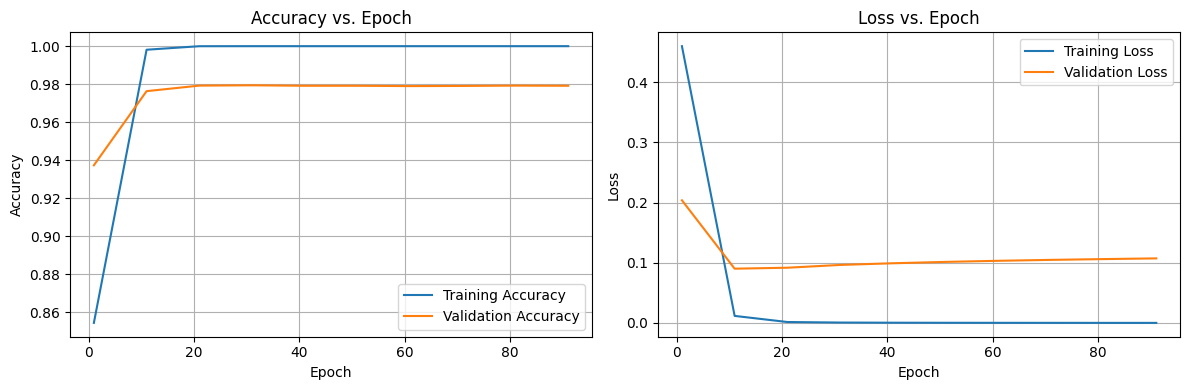

In [16]:
# plot accuracy and loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(list(range(1, iteration + 1, 10)), train_accuracy_list, label='Training Accuracy')
plt.plot(list(range(1, iteration + 1, 10)), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(list(range(1, iteration + 1, 10)), train_loss_list, label='Training Loss')
plt.plot(list(range(1, iteration + 1, 10)), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()